### Hannah's Week 4 Objective:
*    Work with the issue of countour within contour, i.e., epithelium within epithelium

#### Approach
1. Test previous hierarchy logic code on correctly extracted QuPath annotations to see if issues persist.
      
      This revealed the issue detailed below with the existing image preprocessing used to obtain the binary image 
2. Rethink hierarchy logic
3. If above fails, implement size threshold to avoid previous week's problem case with thousands of contours
4. If above fails, Investigate RETR_CCOMP and RETR_EXTERNAL tags.

Thankfully, steps 3 and 4 proved unecessary as bugs were fixed at step 2.

### Relevant modifications
* Adjusted `get_new_imgs` function to preprocess images
  * Inverted grayscale image from which binary image is derived, since cv2 treats white objects as foreground and black objects as background. Without this the entire contour-extraction pipeline would fail as it recognizes the rectangular image boundary as a parent to all contours in the image, causing our desired contours to fail both tests.
* "Donut" definition now entails a contour with a child but no parent. This removes the error from last week where contours with many children would fail to pass the validity check.
* Tested new definition on correctly extracted QuPath annotations, and is successful for all test cases
* For ease of debugging, `find_contours` now returns both the desired contours and the hierarchy object. This has impacted the first line of code in `process_contours`

In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

#Read image and threshold for mask:
#This basic method works best with already cropped cells
#I have another at the bottom that is slightly better for cells with backgrounds

def get_new_imgs(file_path):
    image1=cv2.imread(file_path)
    image1_gray = cv2.bitwise_not(cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)) # invert grayscale image
    _,whole_thresh= cv2.threshold(image1_gray, 127, 255, cv2.THRESH_BINARY)

    return whole_thresh, image1_gray

In [ ]:
def find_contours(binary_image):
    '''find relevant contours of an image'''
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    valid_contours = []
    # loop through all found contours for donuts and islands
    for idx, contour in enumerate(contours):
        child = hierarchy[0][idx][2]
        parent = hierarchy[0][idx][3]
        if child != -1 and parent == -1: # eldest - largest of any nested contours
            valid_contours.append(contour)
        elif child == -1 and parent == -1: # island (no parents or children)
            valid_contours.append(contour)
    # check to make sure contours meet size threshold                   
    return valid_contours, hierarchy

def draw_contours(binary_image, contours):
    all_points = [[0, 0]]
    #Loop over all contours in image and ershape into xy pairings
    for contour in contours:    
        points = np.array(contour.reshape(-1,2))
        all_points = np.concatenate((all_points, points))
    # draw contour points over image of tissue slice
    plt.imshow(binary_image, aspect='equal',  cmap = "gray")
    plt.scatter(np.array(all_points)[:,0], np.array(all_points)[:,1], c='red', marker='o', s = 1)
    plt.show()

Code in the cell below is borrowed directly from Ryan's 'Normal Squares Toggleable' notebook with no modifications.

In [2]:
def calculate_contour_normals(contours,smoothing_size=5):
    '''Calculate normal vector along contour points'''

    all_normals=[]
    
    #Loop over all contours in image
    for contour in contours:
        #Reshape into xy pairings
        points=contour.reshape(-1,2)
        n_points=len(points)
        tangents=np.zeros_like(points,dtype=float)

        #Calculate tangent using smoothing
        for i in range(n_points):
            prev_idx=(i-smoothing_size)%n_points
            next_idx=(i+smoothing_size)%n_points
            tangent=points[next_idx]-points[prev_idx]
            tangent=tangent/(np.linalg.norm(tangent)+1e-8)
            tangents[i]=tangent
            

        #Convert to normal
        normals=np.zeros_like(tangents)
        normals[:,0]=-tangents[:,1]
        normals[:,1]=tangents[:,0]
        
        #add to list of all contour normals
        all_normals.append(normals)

    return all_normals

def calculate_square_corners(point,normal,square_size,binary_image,variable_length=True):
    '''Calculate corners of square normal to point'''

    tangent=np.array([-normal[1],normal[0]])
    half_size=square_size//2
    extended_length=square_size

    #Loop to find variable length
    if variable_length:
        i=square_size
        while True:
            #Increase i while extending into cell
            test_point=point-(normal*i).astype(int)
            test_point=np.clip(test_point,0,np.array(binary_image.shape[:2])[::-1] - 1)

            if binary_image[test_point[1],test_point[0]]==0:
                break
            #if i>=1024:
            #    break #Maximum square size as to not be huge
            i+=2

        extended_length=i
        half_size=i//2

    corners = np.array([
        point + (tangent * half_size),
        point - (tangent * half_size),
        point - (tangent * half_size) - (normal * extended_length),
        point + (tangent * half_size) - (normal * extended_length)
    ])

    return corners, extended_length

def calculate_square_overlap(square1,square2):
    '''Calculate overlap ratio between squares'''

    square1=Polygon(square1)
    square2=Polygon(square2)

    if not square1.intersects(square2):
        return 0
    
    intersection_area=square1.intersection(square2).area
    smallest_area=min(square1.area,square2.area)
    return intersection_area/smallest_area

def create_dense_squares(contours,normals,binary_image,square_size=128,step=5,variable_length=True):
    '''Create many squares along external contours at regular interval'''

    all_squares=[]


    #Loop over all contours 
    for contour,contour_normals in zip(contours, normals):
        points=contour.reshape(-1,2)
        n_points=len(points)
        squares=[]

        #Find corners at step length
        for i in range(0,n_points,step):
            corners,length=calculate_square_corners(points[i],contour_normals[i],square_size,binary_image,variable_length)

            if length>=2048 or length<16: #Trying to avoid badly sized squares
                continue

            squares.append(corners)

        all_squares.append(squares)
    return all_squares

def remove_overlapping_squares(all_squares, overlap_thresh=0.3, look_back=5, second_pass=True):
    final_squares_list = []

    # First pass: remove overlaps within each contour
    for squares in all_squares:
        # Keep first square
        kept_squares = [squares[0]]

        # Check squares within the same contour
        for i in range(1, len(squares)):
            overlap_found = False
            current_square = squares[i]

            # Check within look_back in same contour
            for j in range(max(0, len(kept_squares) - look_back), len(kept_squares)):
                overlap = calculate_square_overlap(current_square, kept_squares[j])
                if overlap > overlap_thresh:
                    overlap_found = True
                    break

            if not overlap_found:
                kept_squares.append(current_square)
        
        final_squares_list.append(kept_squares)

    # Second pass: check against ALL squares across ALL contours
    if second_pass:
        # Flatten all squares
        all_squares_flattened = [square for contour_squares in final_squares_list for square in contour_squares]
        final_refined_squares_list = []

        # Check each contour's squares
        for contour_squares in final_squares_list:
            refined_squares = []

            # Check each square against ALL other squares
            for square in contour_squares:
                overlap_found = False
                
                # Check against all flattened squares
                for other_square in all_squares_flattened:
                    if not np.array_equal(square, other_square):
                        overlap = calculate_square_overlap(square, other_square)
                        if overlap > overlap_thresh:
                            overlap_found = True
                            break
                
                # Only add if no significant overlap found
                if not overlap_found:
                    refined_squares.append(square)
            
            final_refined_squares_list.append(refined_squares)

        return final_refined_squares_list

    return final_squares_list

def draw_squares(image,squares_list,color=[255,0,0],thickness=50):
    '''Draw squares on image'''

    result=image.copy()

    for squares in squares_list:
        for square in squares:
            points=square.astype(np.int32)
            cv2.polylines(result,[points],isClosed=True,color=color,thickness=thickness)  
    return result

def process_contours(image,binary_image,square_size=128,step=5,overlap_thresh=0.3,
                    smoothing_size=5,look_back=3,second_pass=True,variable_length=False):
    """
    Main function to process multiple contours and generate aligned squares along them.
    
    Args:
        image (np.ndarray): Original image
        binary_image (np.ndarray): Binary mask of the shapes
        square_size (int): Base size of squares
        step (int): Points to skip between squares
        overlap_thresh (float): Maximum allowed overlap between squares
        smoothing_size (int): Points to consider for normal calculation
        look_back (int): Squares to check for overlap
        second_pass (bool): Whether to do precise overlap checking
        variable_length (bool): Whether to use variable length squares
        
    Returns:
        tuple: (processed image, contours, squares_list)
    """
    contours=find_contours(binary_image)[0]
    if not contours:
        return TypeError('No contours found')
    
    
    normals=calculate_contour_normals(contours,smoothing_size)
    squares_list=create_dense_squares(
        contours,normals,binary_image,
        square_size=square_size,
        step=step,
        variable_length=variable_length
    )
    
    final_squares_list=remove_overlapping_squares(
        squares_list,
        overlap_thresh=overlap_thresh,
        look_back=look_back,
        second_pass=second_pass
    )
    
    result = draw_squares(image,final_squares_list)
    plt.imshow(result, cmap='bone')
    
    return result, contours, final_squares_list

### Below are tests of the new contour extraction logic on QuPath annotations

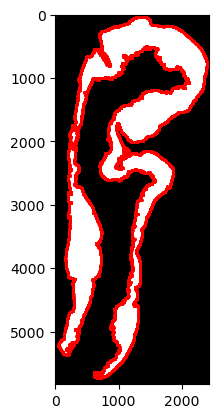

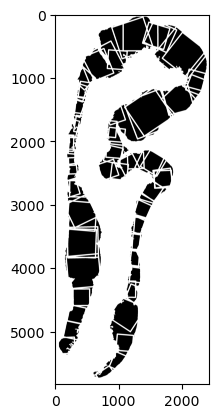

In [234]:
whole_thresh, img_gray = get_new_imgs("testing_slices/case_001_h&e_4.png") 
contours, h = find_contours(whole_thresh)
draw_contours(whole_thresh, contours)
result_image, contour, squares = process_contours(
     img_gray,
     whole_thresh,
     square_size=256,
     step=60,
     overlap_thresh=0.1,
     smoothing_size=200,
     look_back=5,
     second_pass=False,
     variable_length=True)

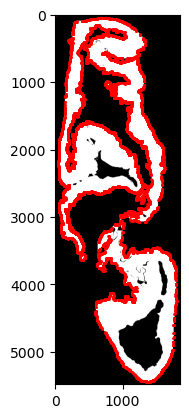

KeyboardInterrupt: 

In [ ]:
whole_thresh, img_gray = get_new_imgs("testing_slices/Case_002_h&e.png") 
contours, h = find_contours(whole_thresh)
draw_contours(whole_thresh, contours)

result_image, contour, squares = process_contours(
     img_gray,
     whole_thresh,
     square_size=256,
     step=60,
     overlap_thresh=0.1,
     smoothing_size=200,
     look_back=5,
     second_pass=False,
     variable_length=True)

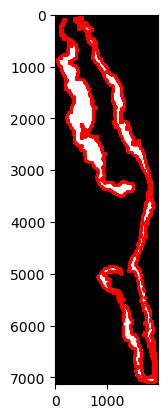

In [219]:
whole_thresh, img_gray = get_new_imgs("testing_slices/Case_004_h&e.png") 
contours, h = find_contours(whole_thresh)
draw_contours(whole_thresh, contours)
# result_image, contour, squares = process_contours(
#      img_gray,
#      whole_thresh,
#      square_size=256,
#      step=60,
#      overlap_thresh=0.1,
#      smoothing_size=200,
#      look_back=5,
#      second_pass=False,
#      variable_length=True)

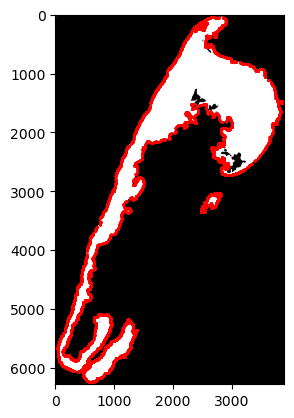

In [220]:
whole_thresh, img_gray = get_new_imgs("testing_slices/Case_009_h&e.png") 
contours, h = find_contours(whole_thresh)
draw_contours(whole_thresh, contours)
# result_image, contour, squares = process_contours(
#      img_gray,
#      whole_thresh,
#      square_size=256,
#      step=60,
#      overlap_thresh=0.1,
#      smoothing_size=200,
#      look_back=5,
#      second_pass=False,
#      variable_length=True)

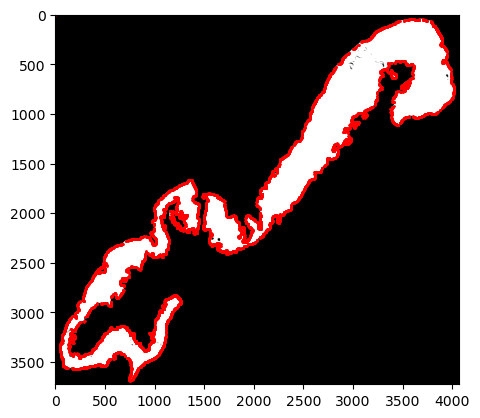

In [221]:
whole_thresh, img_gray = get_new_imgs("testing_slices/Case_010_h&e.png") 
contours, h = find_contours(whole_thresh)
draw_contours(whole_thresh, contours)
# result_image, contour, squares = process_contours(
#      img_gray,
#      whole_thresh,
#      square_size=256,
#      step=60,
#      overlap_thresh=0.1,
#      smoothing_size=200,
#      look_back=5,
#      second_pass=False,
#      variable_length=True)

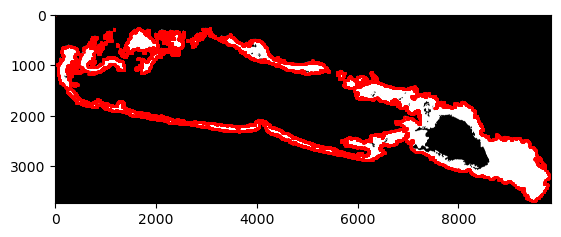

KeyboardInterrupt: 

In [241]:
whole_thresh, img_gray = get_new_imgs("testing_slices/case_30_h&e.png") 
contours, h = find_contours(whole_thresh)
draw_contours(whole_thresh, contours)
result_image, contour, squares = process_contours(
     img_gray,
     whole_thresh,
     square_size=256,
     step=60,
     overlap_thresh=0.1,
     smoothing_size=200,
     look_back=5,
     second_pass=False,
     variable_length=True)

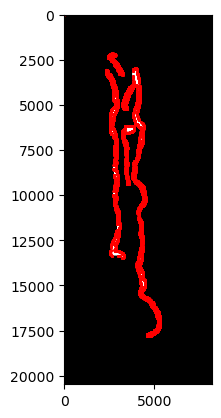

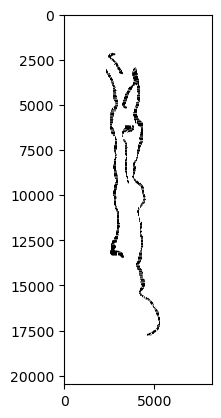

In [240]:
whole_thresh, img_gray = get_new_imgs("testing_slices/Case_053_h&e.png") 
contours, h = find_contours(whole_thresh)
draw_contours(whole_thresh, contours)
result_image, contour, squares = process_contours(
     img_gray,
     whole_thresh,
     square_size=256,
     step=60,
     overlap_thresh=0.1,
     smoothing_size=200,
     look_back=5,
     second_pass=False,
     variable_length=True)

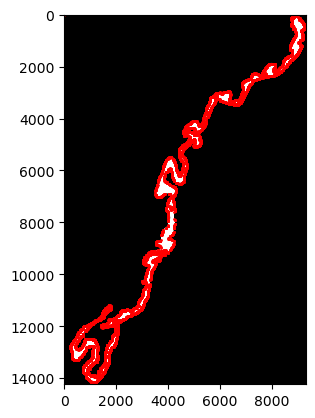

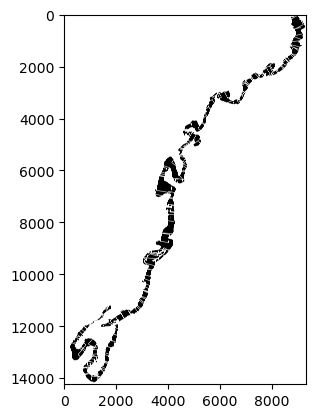

In [239]:
whole_thresh, img_gray = get_new_imgs("testing_slices/Case_89_h&e.png") 
contours, h = find_contours(whole_thresh)
draw_contours(whole_thresh, contours)
result_image, contour, squares = process_contours(
     img_gray,
     whole_thresh,
     square_size=256,
     step=60,
     overlap_thresh=0.1,
     smoothing_size=200,
     look_back=5,
     second_pass=False,
     variable_length=True)

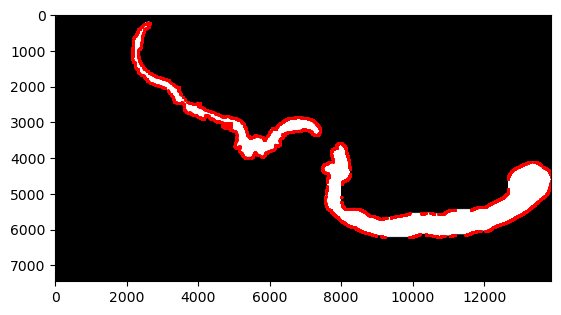

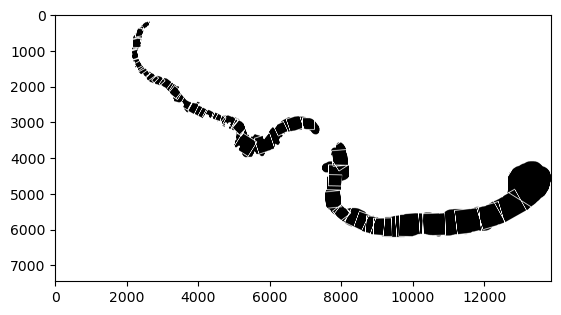

In [238]:
whole_thresh, img_gray = get_new_imgs("testing_slices/Case_102_h&e.png") 
contours, h = find_contours(whole_thresh)
draw_contours(whole_thresh, contours)
result_image, contour, squares = process_contours(
     img_gray,
     whole_thresh,
     square_size=256,
     step=60,
     overlap_thresh=0.1,
     smoothing_size=200,
     look_back=5,
     second_pass=False,
     variable_length=True)

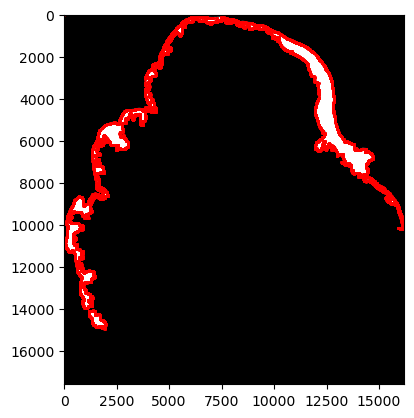

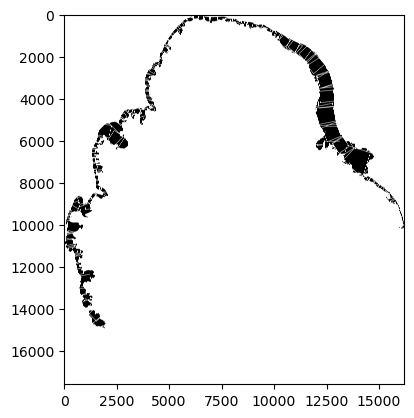

In [235]:
whole_thresh, img_gray = get_new_imgs("testing_slices/Case_104_h&e.png") 
contours, h = find_contours(whole_thresh)
draw_contours(whole_thresh, contours)
result_image, contour, squares = process_contours(
     img_gray,
     whole_thresh,
     square_size=256,
     step=60,
     overlap_thresh=0.1,
     smoothing_size=200,
     look_back=5,
     second_pass=False,
     variable_length=True)

### Finally, a test on the case that failed last week:

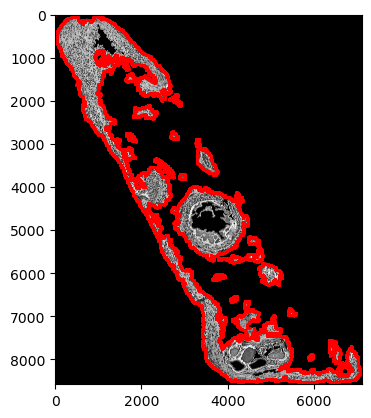

KeyboardInterrupt: 

In [237]:
img_gray, whole_thresh = get_new_imgs("testing_slices/h2114155 h&e_ROI_4 Epithelia.png") 
contours, h = find_contours(whole_thresh)
draw_contours(whole_thresh, contours) 
result_image, contour, squares = process_contours(
     img_gray,
     whole_thresh,
     square_size=256,
     step=60,
     overlap_thresh=0.1,
     smoothing_size=200,
     look_back=5,
     second_pass=False,
     variable_length=True)